In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/data/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/NN/all_length_cnn_lstm.h5')

In [2]:
conv1d_layer = model.layers[0]

# Extract the weights from the Conv1D layer
filters = conv1d_layer.get_weights()[0]

In [59]:
filters[:, :, 0]

array([[-0.0312642 ,  0.03401838, -0.37462515,  0.10310968],
       [-0.29081145, -0.01229189, -0.645383  ,  0.23456712],
       [-0.14397347,  0.08107748, -0.15367086,  0.15568052],
       [-0.09892169, -0.17917216,  0.02703198,  0.1103544 ],
       [-0.04438764, -0.15655239,  0.06150081, -0.02245142],
       [ 0.00708188, -0.0383315 , -0.20662732,  0.02940323],
       [ 0.2748113 , -0.09648088, -0.4191858 , -0.29674107],
       [ 0.09898784,  0.02259724,  0.09221309, -1.0756314 ],
       [-1.0974964 , -0.12826805,  0.32114723, -0.19673078],
       [ 0.16175778, -0.5254797 , -0.03144366, -0.65737695],
       [ 0.0492925 , -0.10200568, -0.23060395, -0.12354749],
       [-0.06800004, -0.5272013 ,  0.06366147, -0.06948801],
       [-0.2629285 , -0.19512925,  0.29434538, -0.20748287],
       [-0.08666214, -0.10591916,  0.00477393, -0.11109819],
       [-0.17910828,  0.19161893, -0.19624226, -0.04514743],
       [-0.2456064 , -0.04441603, -0.06307913,  0.05382146]],
      dtype=float32)

In [61]:
import numpy as np
def normalize_pwm(pwm, factor=3, max=None):

	if not max:
		max = np.max(np.abs(pwm))
	pwm = pwm/max
	if factor:
		pwm = np.exp(pwm*factor)
	norm = np.outer(np.ones(pwm.shape[0]), np.sum(np.abs(pwm), axis=0))
	return pwm/norm

In [14]:
viz_filters = [filters[:, :, i] for i in range(filters.shape[-1])]

In [9]:
A = [v[:,0] for v in viz_filters]
C = [v[:,1] for v in viz_filters]
G = [v[:,2] for v in viz_filters]
T = [v[:,3] for v in viz_filters]

In [ ]:
import seaborn as sns
g = sns.heatmap([v[:,0] for v in viz_filters], cmap='viridis_r', linewidths=0.5)
g.set_title('Filter weights for A')

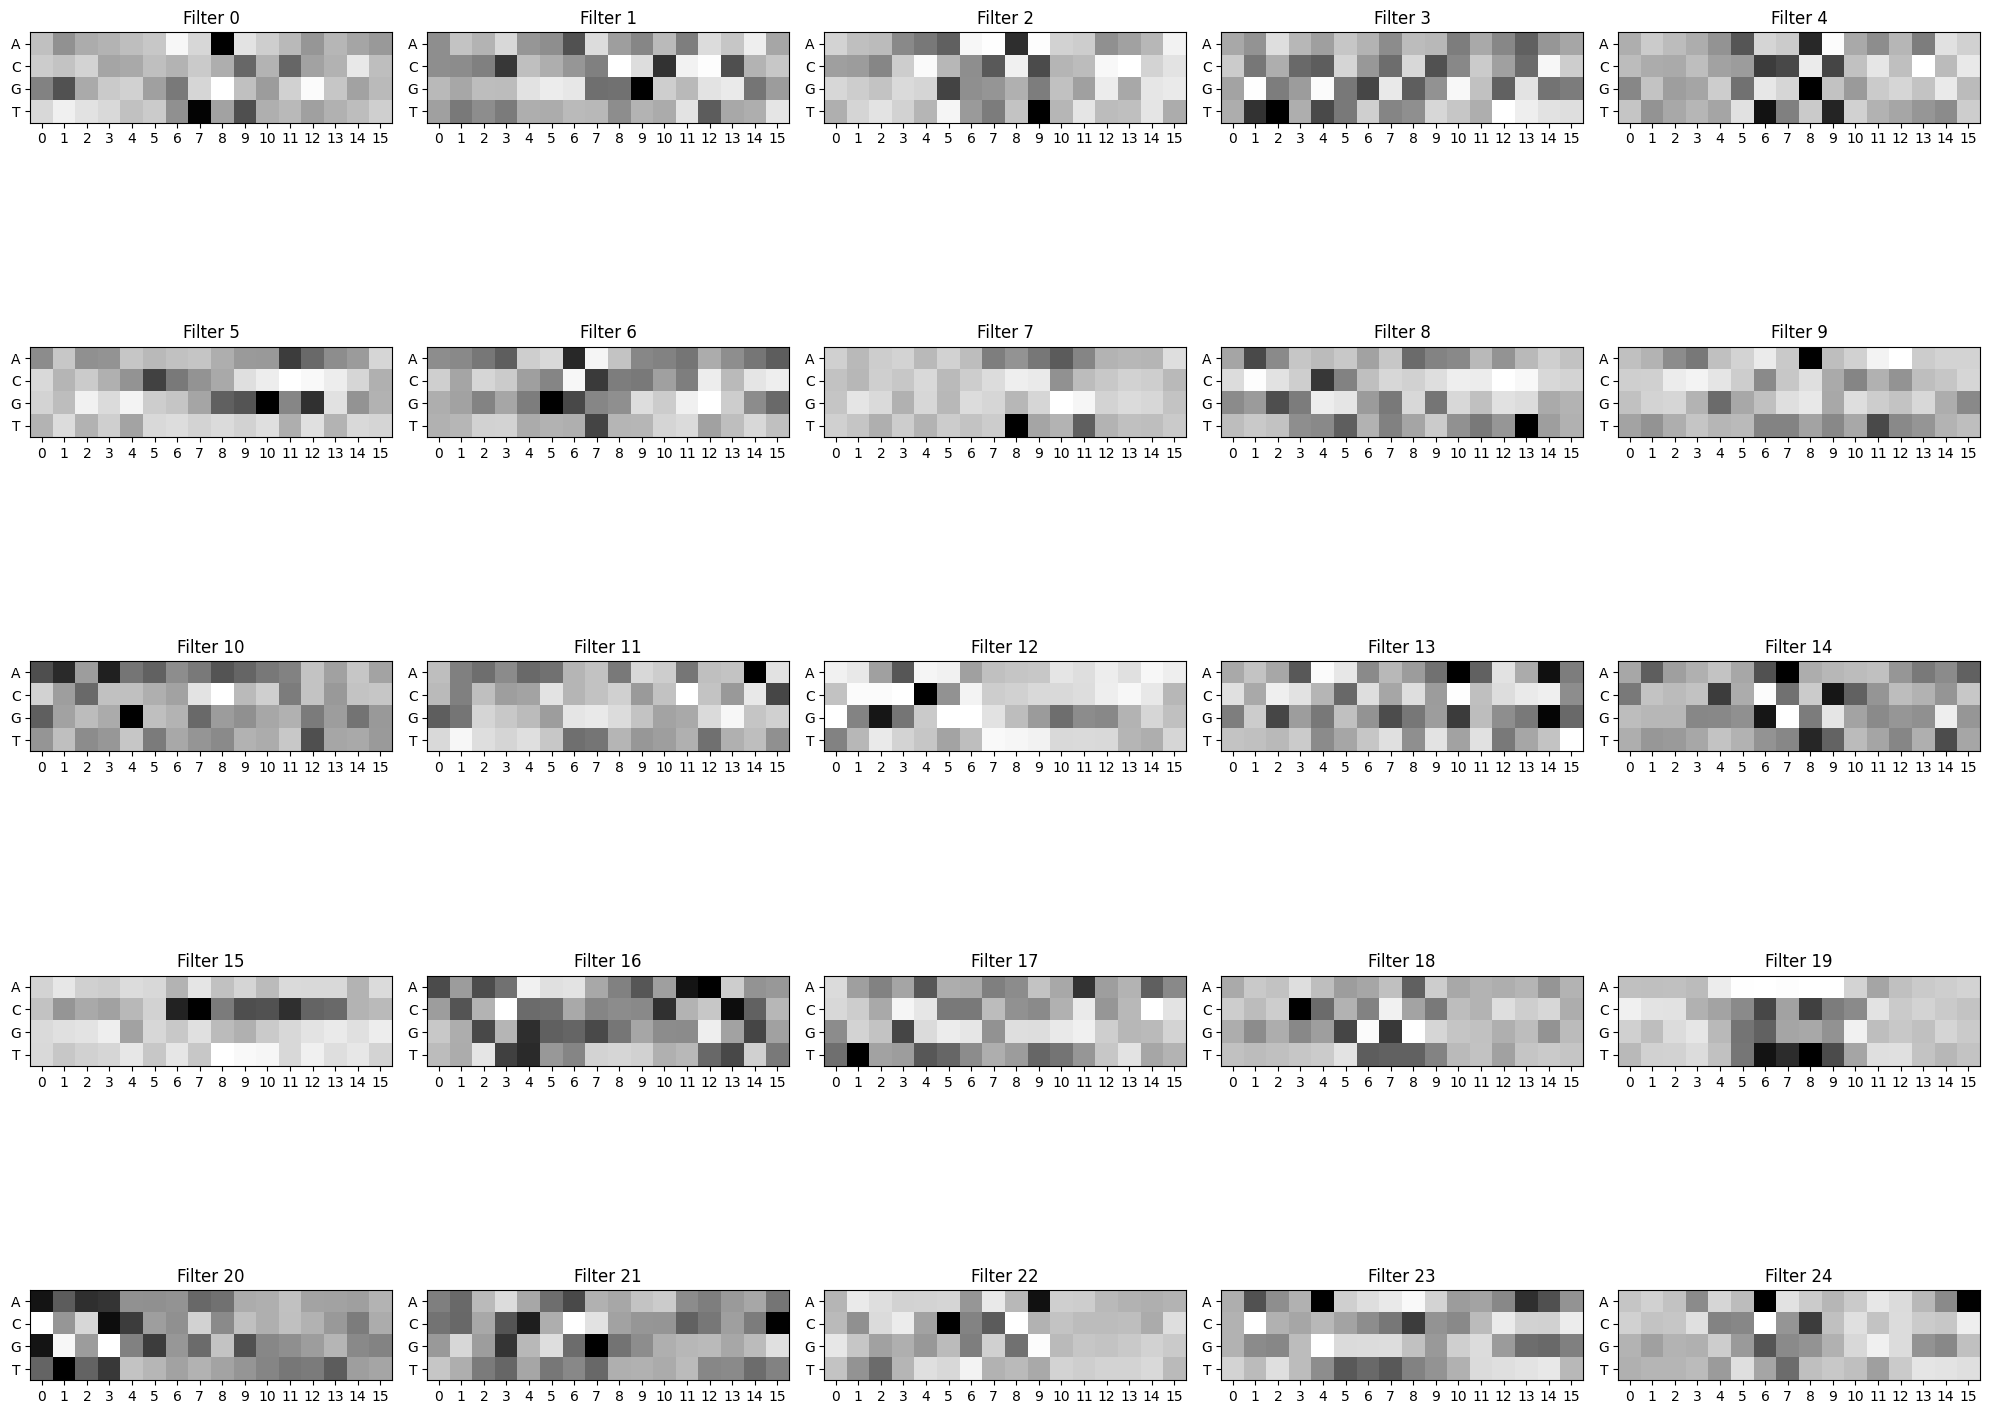

In [132]:
import matplotlib.pyplot as plt
import numpy as np
def view_filters(filters, num_filt=10, filt_width=16, num_cols=2):
    num_rows = num_filt // num_cols
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))
    f = filters[:,:,:num_filt]
    for i in range(num_filt):
        ax = plt.subplot(num_rows,num_cols, i+1)
        ax.imshow(np.transpose(filters[:,:,i]), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
view_filters(filters, 25, 16, 5)

# write to pfm file

In [100]:
from Bio import motifs

mots = []
for i in range(128):
    pfm = {}
    probability_matrix = filters[:,:,i]
    normalized_matrix = normalize_pwm(probability_matrix)
    #normalized_matrix = (normalized_matrix * 100).astype(int)
    for j, nuc in enumerate(["A", "C", "G", "T"]):
        pfm[nuc] = np.transpose(normalized_matrix)[j].tolist()

    m = motifs.Motif(counts=pfm)
    m.name = f"f{i}"
    m.matrix_id="filter_" + str(i)
    mots.append(m)

In [101]:
with open("CNN_filter_motifs_abs.pfm", "w+") as handle:
    for m in mots:
        handle.write(m.format("jaspar"))

In [97]:
m = motifs.Motif(counts=pfm)

In [ ]:
from Bio import motifs
# Print the motif
print(motif.format("jaspar"))
with open("test_motif.pfm", "w+") as handle:
    motifs.write(motifs, handle, "jaspar")

In [ ]:
import logomaker
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

filt = conv1d_layer.get_weights()[0]
# Load the filters
first_filter = np.array(viz_filters).reshape(64, 4, 8)[29]
# Convert to DataFrame
df[["A", "C", "G", "T"]] = scaler.fit_transform(pd.DataFrame(viz_filters).T)
df.columns = ['A', 'C', 'G', 'T']
logomaker.Logo(df)

# Generate a saliency map

In [19]:
import Bio.SeqIO as SeqIO 
import random
import tqdm
def remove_N(seq):
    """
    Remove Ns from sequence
    """
    return seq.upper().replace("N", "")

def onehote(seq):
    """
    One Hot encoding function
    """
    seq2=list()
    mapping = {"A":[1., 0., 0., 0.], "C": [0., 1., 0., 0.], "G": [0, 0., 1., 0.], "T":[0., 0., 0., 1.], "N":[0., 0., 0., 0.]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0., 0., 0., 0.]) 
    return np.array(seq2)

import numpy as np
MAX_LEN=4000
MIN_LEN=0
random.seed(10)
LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
LTRs = random.sample(LTRs, 5000)


sequences = [onehote(remove_N(str(rec.seq))) for rec in tqdm.tqdm(LTRs)]
paddedDNA = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="pre", maxlen=3000)

100%|██████████| 5000/5000 [00:00<00:00, 5476.91it/s]


In [20]:
paddedDNA[0:1, :, :].shape

(1, 3000, 4)

In [21]:
@tf.function
def compute_saliency_map(model, input_sequence):
    threshold = 0.5  # You can adjust this threshold as needed
    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        predictions = model(input_sequence)
        predicted_class =  tf.cast(predictions > threshold, tf.int32)
        loss = predictions.numpy()[:, predicted_class]
    gradients = tape.gradient(loss, input_sequence)
    saliency = tf.reduce_sum(tf.abs(gradients), axis=-1)
    return saliency

def compute_saliency_map(model, input_sequence):
    input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        predictions = model(input_sequence, training=False)[:, 0] # Only one sample

    gradients = tape.gradient(predictions, input_sequence)
    saliency = tf.abs(gradients)

    # Normalize gradients
    saliency /= tf.reduce_max(saliency)

    return saliency.numpy()


In [22]:
sample_sequence = paddedDNA[0:20, :, :]

# Compute the saliency map for the sample sequence
saliency_map = compute_saliency_map(model, paddedDNA)

In [23]:
from scipy.special import softmax

normalized_array = softmax(saliency_map.mean(axis=0).mean(axis=1))
sm_mean = saliency_map.mean(axis=0).mean(axis=1)

<Axes: >

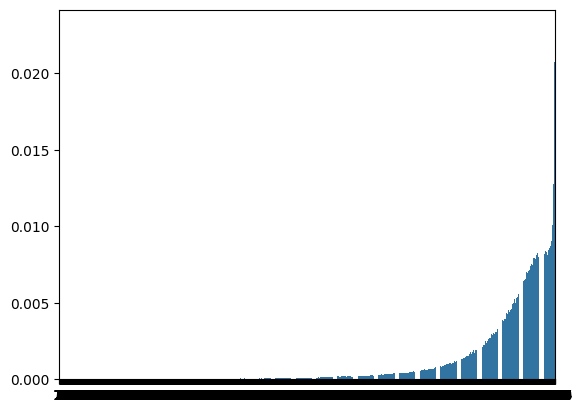

In [24]:
import seaborn as sns 
sns.barplot(y = sm_mean, x=range(3000))